# A simple introduction to spiking neurons

Spiking neural networks are considered to be the *third generation* of neural networks, preceeded by McCulloch-Pitts threshold neurons ("first generation") which produced digital outputs and Artificial Neural Networks with continuous activations, like sigmoids and hyperbolic tangets, ("second generation") that are commonly used these days.

## Artificial Neuron (AN) Model

The standard artificial neuron model used most commonly in ANNs and DNNs is a simple equation

$\vec{y} = \Theta(W.\vec{x} + b)$

where $\Theta$ is typically a non linear activation function such as a *sigmoid* or *hyperbolic tangent* function.

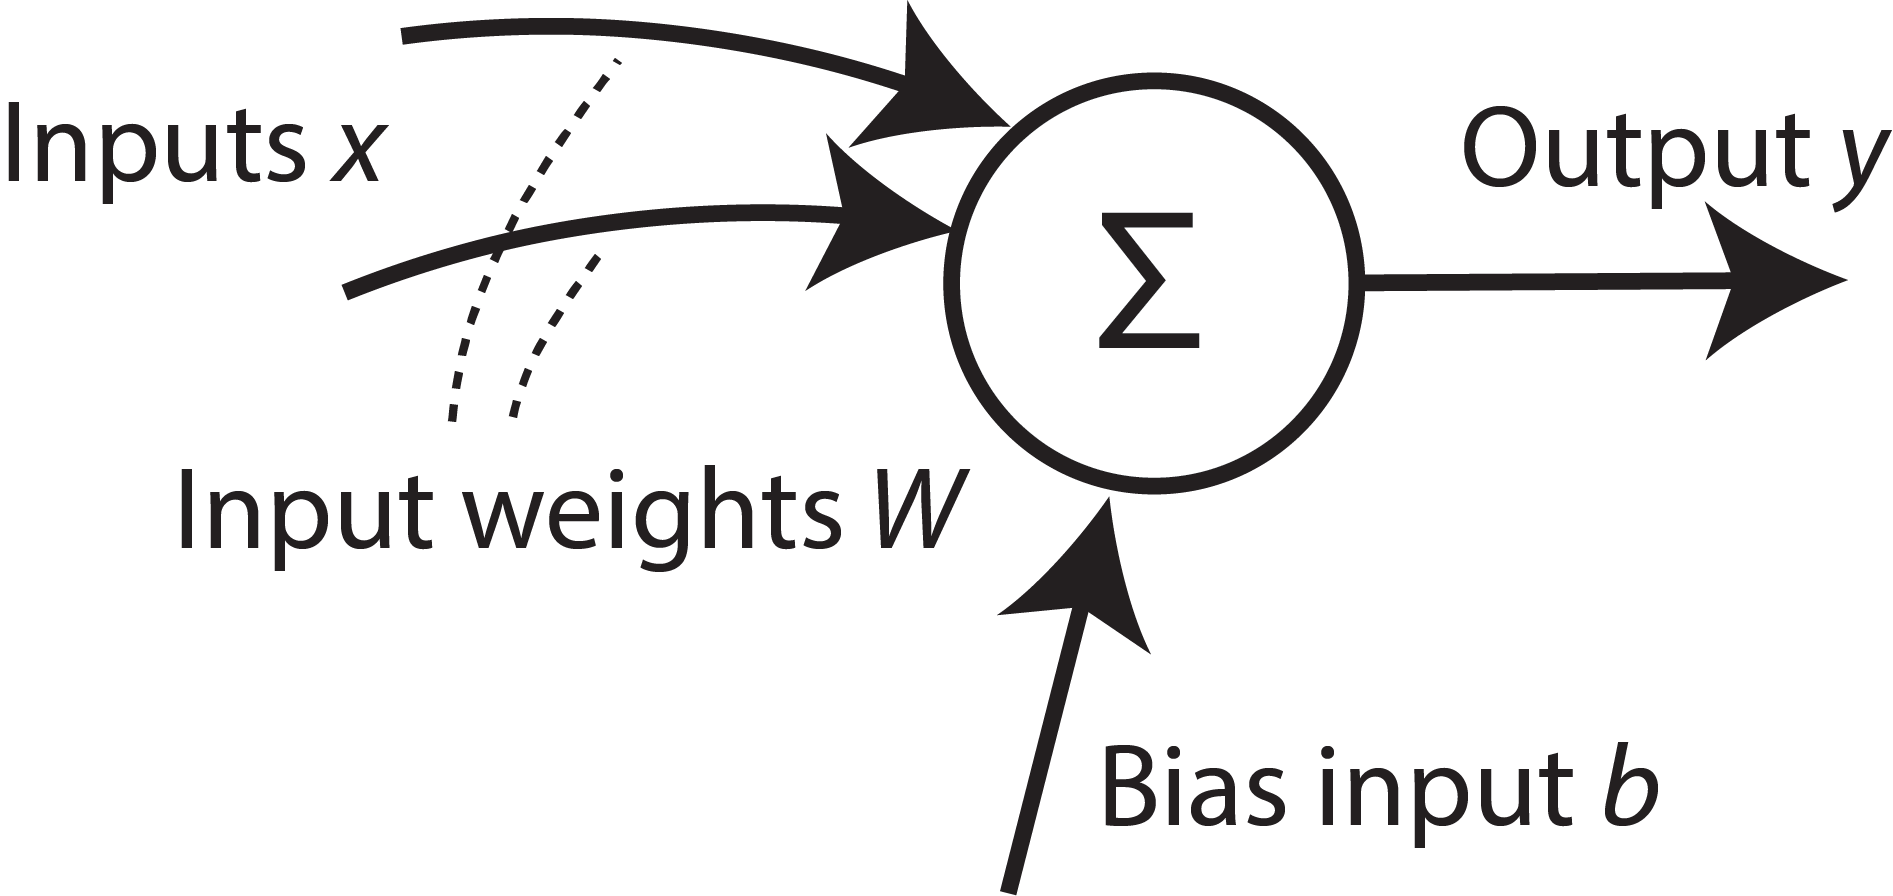

In [1]:
from IPython.display import Image
Image(filename='AN-neuron.png', width=300)

**Note that the output depends only on the instantaneous inputs. The neuron does not have an internal state that would affect its output.**

This is where spiking neurons and spiking neural networks (SNNs) come into play. They add an additional dependence on the current state of the neuron, and include explicit temporal dynamics. They also communicate with each other using pulsed events called "spikes".

## Leaky Integrate and Fire (LIF) model

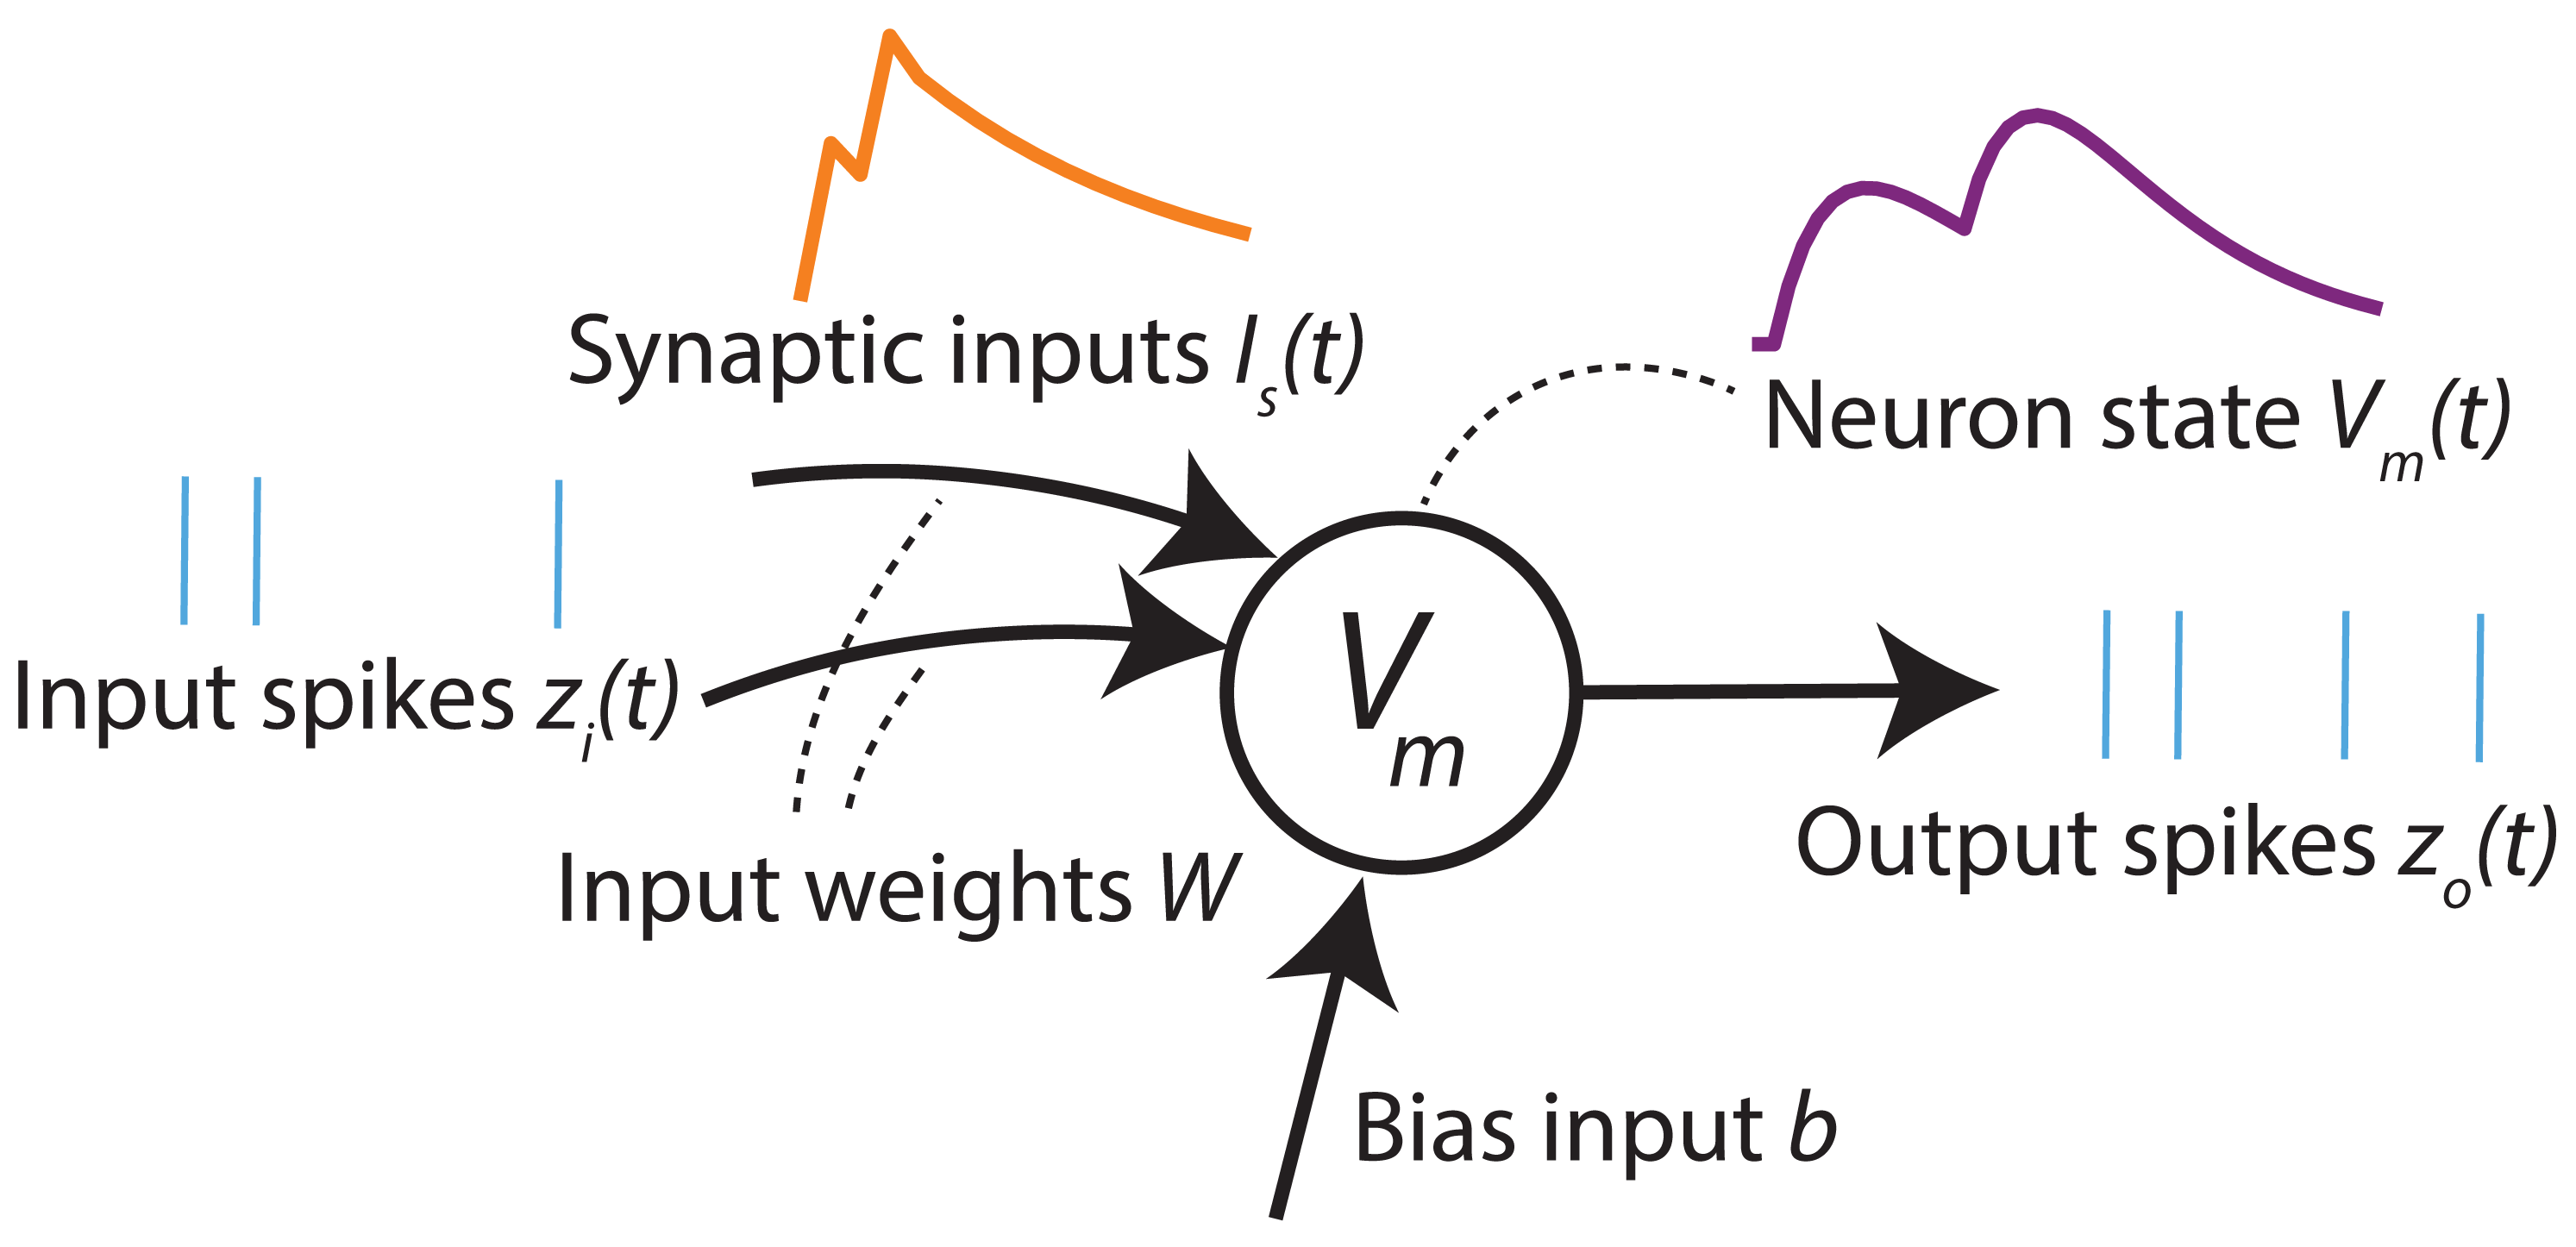

In [2]:
Image(filename='LIF-neuron-full.png', width=500)

<div>
    <i>Diagram of a simple spiking neuron. Inputs and outputs are series of event pulses called "spikes". The neuron implements temporal dynamics when integrating the input spikes, and when updating its internal state.</i>
</div>
<br />

### Internal state — "membrane potential"
One of the simplest models of spiking neurons is the Leaky Integrate and Fire (LIF) neuron model, where the state of the neuron, known as the *membrane potential* $V_m(t)$, depends on its previous state in addition to its inputs. The dynamics of this state can be described as follows:

$$\tau_m \cdot d{V_m}/dt = - V_m(t) + I_s(t) + I_b$$

where $\tau_m$ is the membrane time constant, which determines how much the neuron depends on its previous states and inputs and therefore defines the neuron's memory; and $I_b$ is a constant bias.

The linear equation above describes the dynamics of a system with "leaky" dynamics ie over time, the membrane potential $V$ slowly "leaks" to $0$. This is why the neuron model is referred to as a **Leaky Integrate and Fire Neuron model**.

Note that there is an explicit notion of time, which does not occur in the standard artificial neuron model above.

### Synaptic inputs
Spiking input is integrated onto the membrane of the neuron via a synaptic current $I_s(t)$, which has its own dynamics:

$\tau_s \cdot d{I}_s/dt + I_s(t) = \sum_i w_i \cdot \sum_j \delta(t-t_j^{i})$

where $\sum_j \delta(t-t_j^i)$ is a stream of spikes from presynaptic neuron $i$ occurring at times $t_j^i$. The values $w_i$ represent the corresponding weights. The synaptic currents decay towards zero under the synaptic time constant $\tau_s$.

Let's simulate the synapse and membrane dynamics with a random spike train input, and see how they evolve. First we will generate a random ("Poisson") spike train, by thresholding random noise.

In [3]:
# - Import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

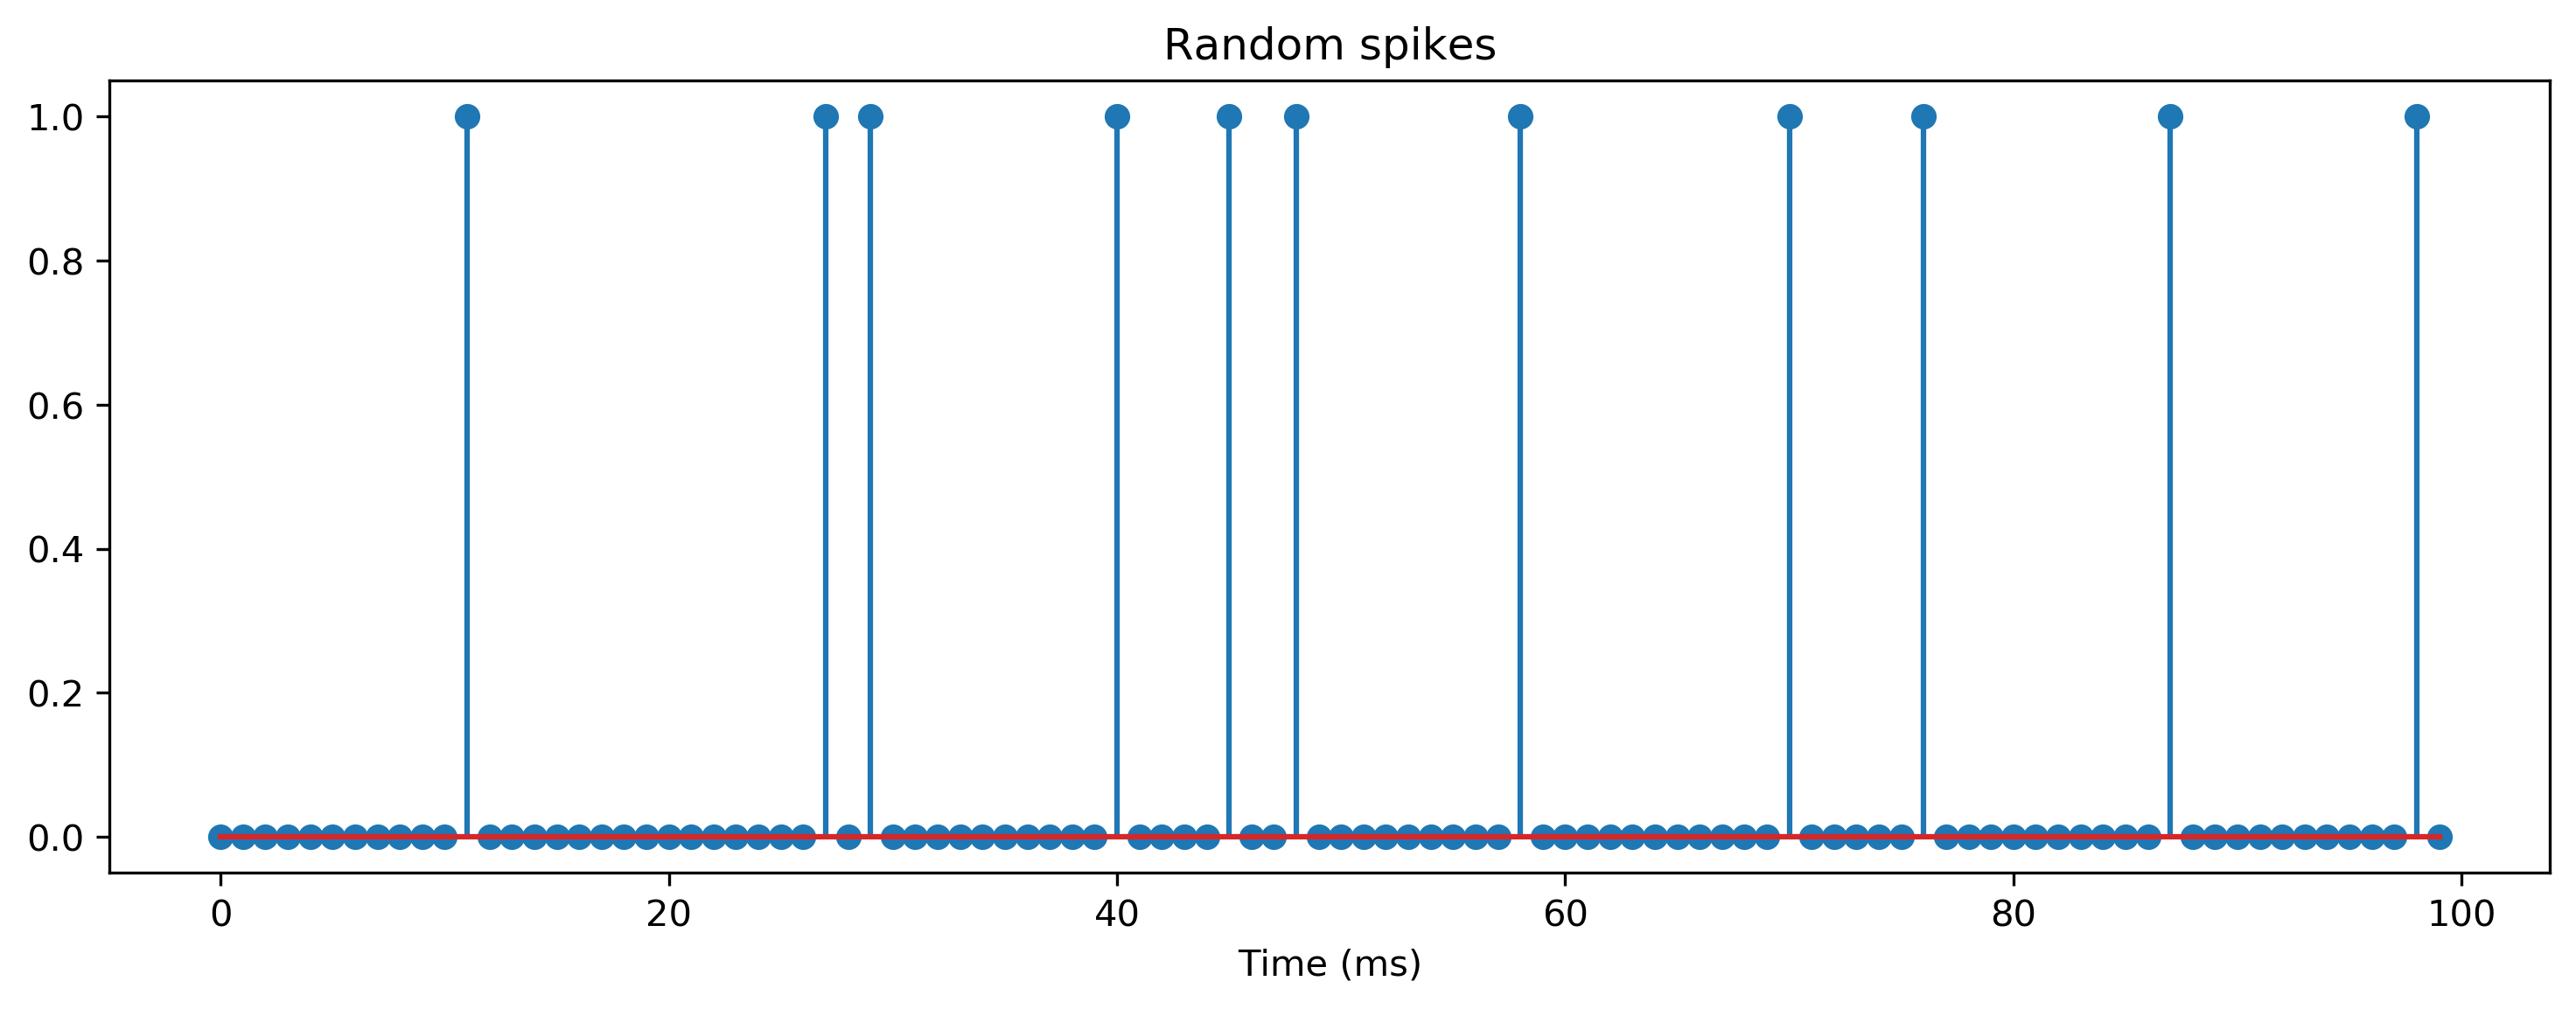

In [4]:
# - Generate a random spike train
T = 100
spike_prob = 0.1
spikes = np.random.rand(T,) < spike_prob

# - Plot the spike train
plt.figure()
plt.stem(spikes, use_line_collection=True)
plt.xlabel('Time (ms)')
plt.title('Random spikes');

Below we implement the synaptic and membrane dynamics by iterating over time, and computing the synapse and membrane values in the simplest possible way. 

In [5]:
# - A simple Euler solver for the synapse and membrane. One time step is 1 ms

tau_m = 10 # ms
tau_s = 10 # ms
V_m = 0 # Initial membrane potential
I_s = 0 # Initial synaptic current
I_bias = 0 # Bias current

V_m_t = []
I_s_t = []

# - Loop over time and solve the synapse and membrane dynamics
for t in range(T):
    # Take account of input spikes
    I_s = I_s + spikes[t]

    # Integrate synapse dynamics
    dI_s = -I_s / tau_s
    I_s = I_s + dI_s
    
    # Integrate membrane dynamics
    dV_m = (-V_m + I_s + I_bias) / tau_m
    V_m = V_m + dV_m
    
    # Save data
    V_m_t.append(V_m)
    I_s_t.append(I_s)

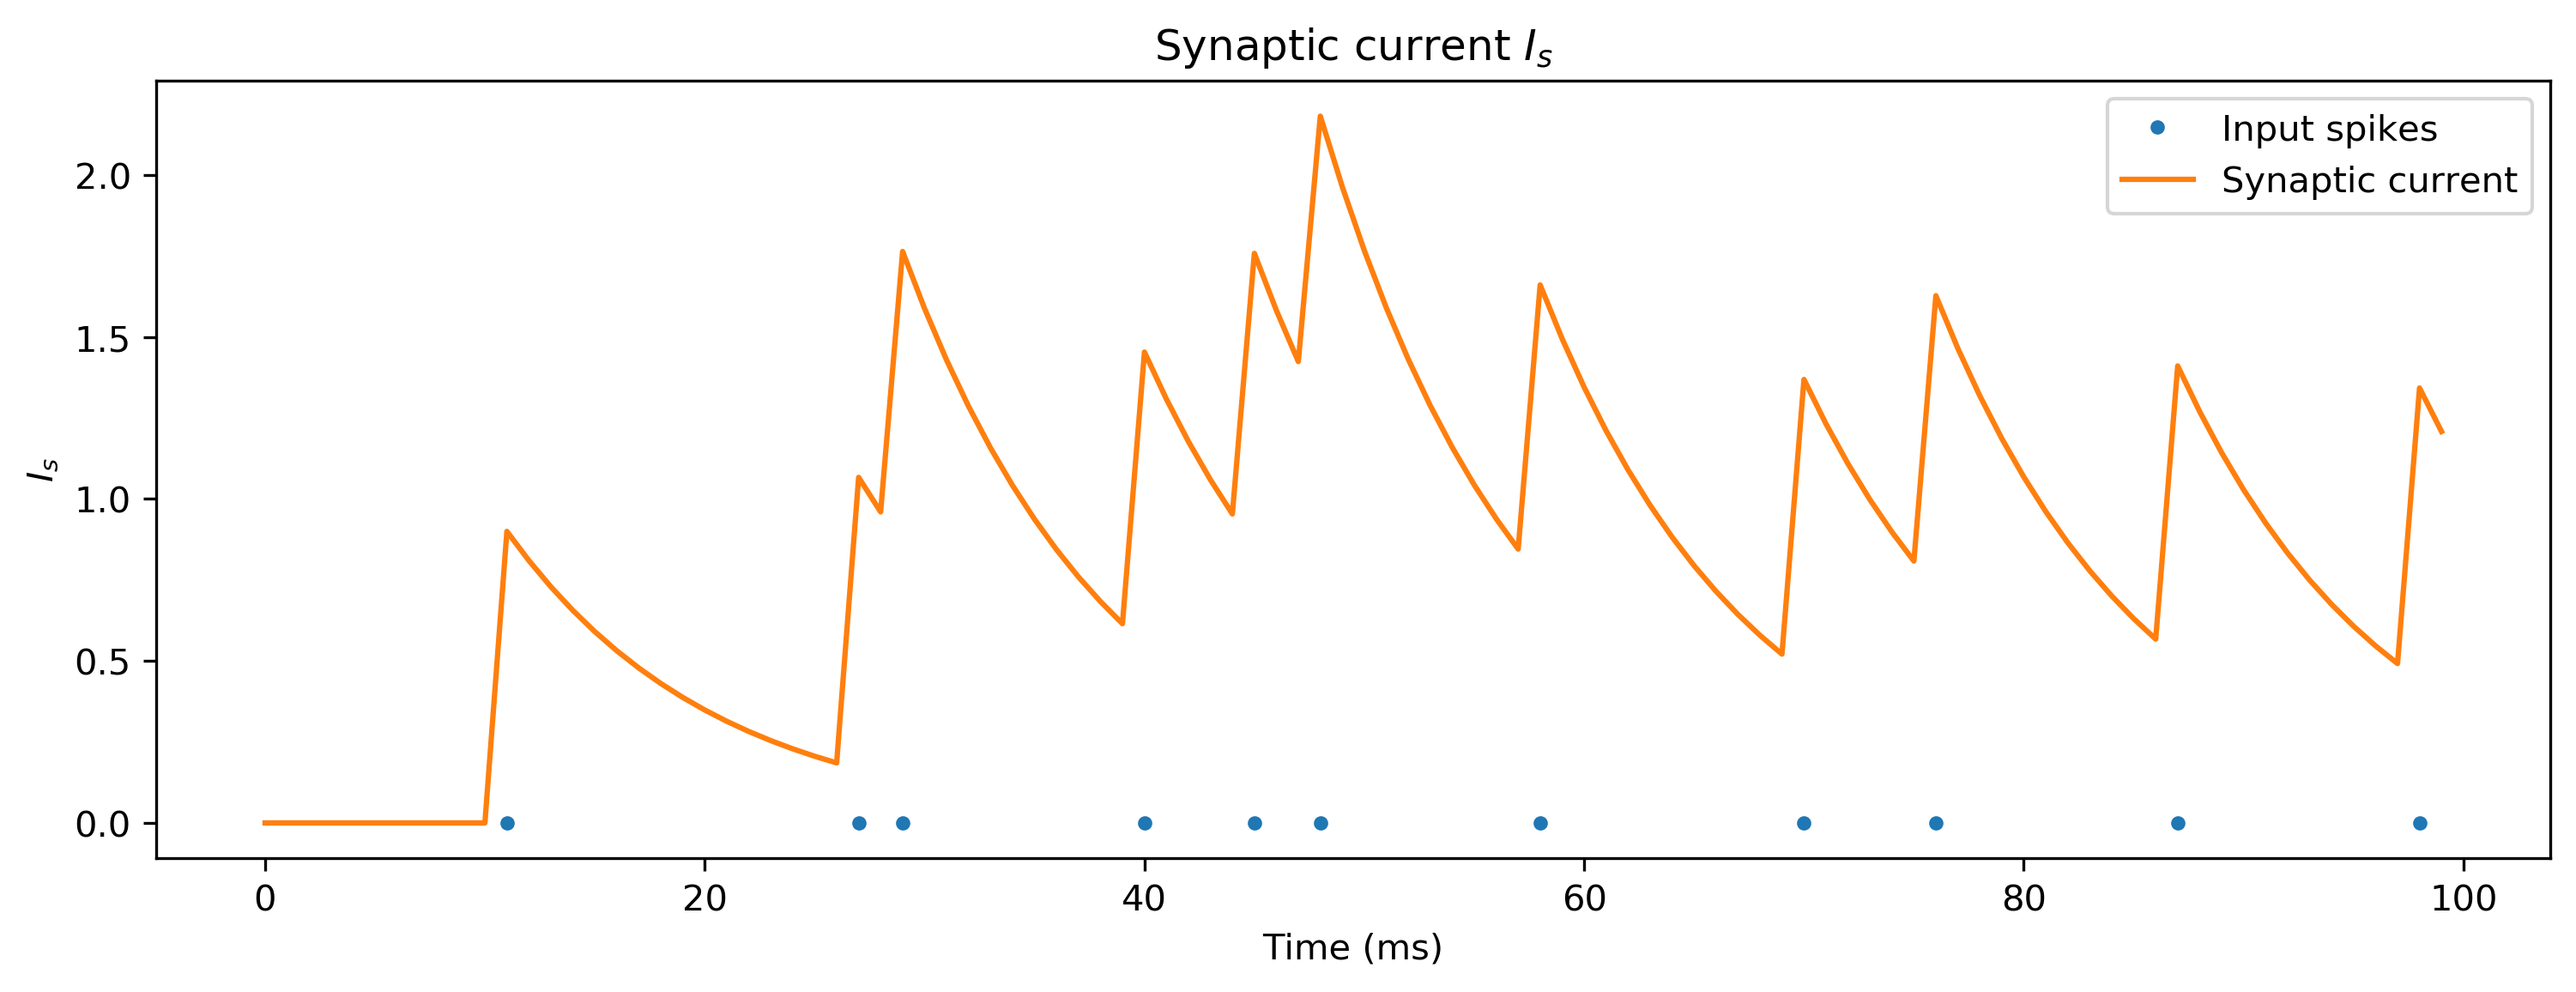

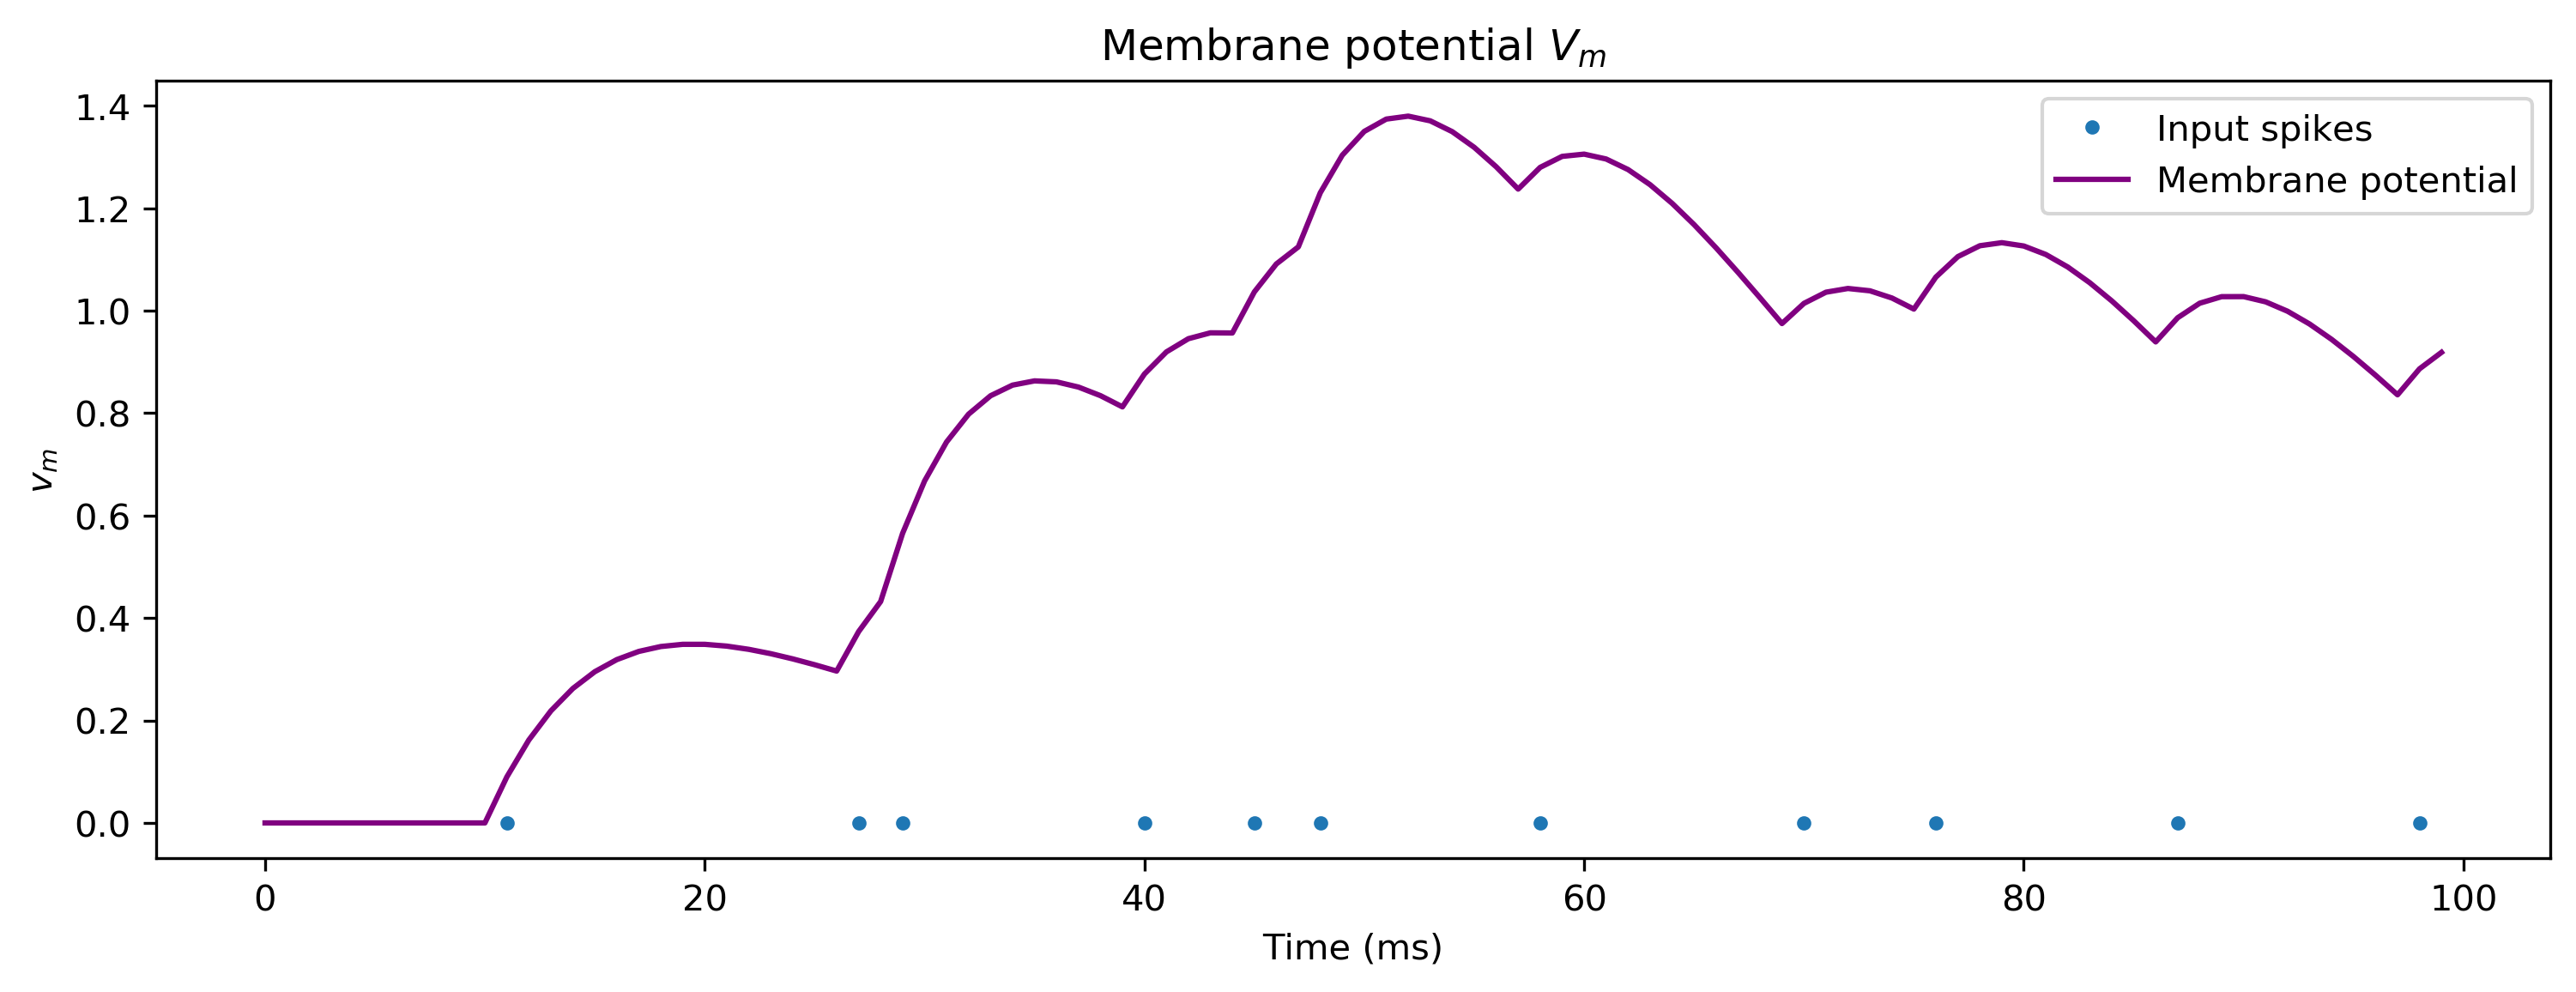

In [6]:
plt.figure()
spike_times = np.argwhere(spikes)
plt.plot(spike_times, np.zeros(len(spike_times)), '.')
plt.plot(I_s_t)
plt.xlabel('Time (ms)')
plt.ylabel('$I_s$')
plt.title('Synaptic current $I_s$')
plt.legend(['Input spikes', 'Synaptic current'])

plt.figure()
plt.plot(spike_times, np.zeros(len(spike_times)), '.')
plt.plot(V_m_t, c='purple')
plt.xlabel('Time (ms)')
plt.ylabel('$v_m$')
plt.legend(['Input spikes', 'Membrane potential'])
plt.title('Membrane potential $V_m$');

### Spiking neuron output
The output of the LIF neuron is binary and instantaneous. It is $1$ only when $V$ reaches a threshold value $V_{th}=1$, upon which the membrane potential is immediately reset by subtracting one.

$V_m(t+\delta) = V_m(t) - V_{th} \text{, if } V_m(t) \geq V_{th}$

$V_m(t+\delta) = V_m(t) \text{, otherwise}$

This instantanious output of $1$ is typically referred to as a "spike" at time $t$. A series of such spikes will hence forth be referred to as $s(t)$.

$s(t) = 1 \text{, if } V_m(t)\geq V_{th}$

$s(t) = 0 \text{, otherwise}$

We can include spike generation and reset into the LIF simulation:

In [7]:
# - A simple Euler solver for the synapse and membrane, including spike generation. One time step is 1 ms

tau_m = 10 # ms
tau_s = 10 # ms
V_m = 0 # Initial membrane potential
V_th = 1 # Spiking threshold potential
I_s = 0 # Initial synaptic current
I_bias = 0 # Bias current

V_m_t = []
I_s_t = []
spikes_t = []

# - Loop over time and solve the synapse and membrane dynamics
for t in range(T):
    # Take account of input spikes
    I_s = I_s + spikes[t]

    # Integrate synapse dynamics
    dI_s = -I_s / tau_s
    I_s = I_s + dI_s
    
    # Integrate membrane dynamics
    dV_m = (1/tau_m)*(-V_m + I_s + I_bias)
    V_m = V_m + dV_m
    
    # - Spike detection
    if V_m > V_th:
        # - Reset
        V_m = V_m - 1
        
        # - Save the spike time
        spikes_t.append(t)
    
    # Save data
    V_m_t.append(V_m)
    I_s_t.append(I_s)

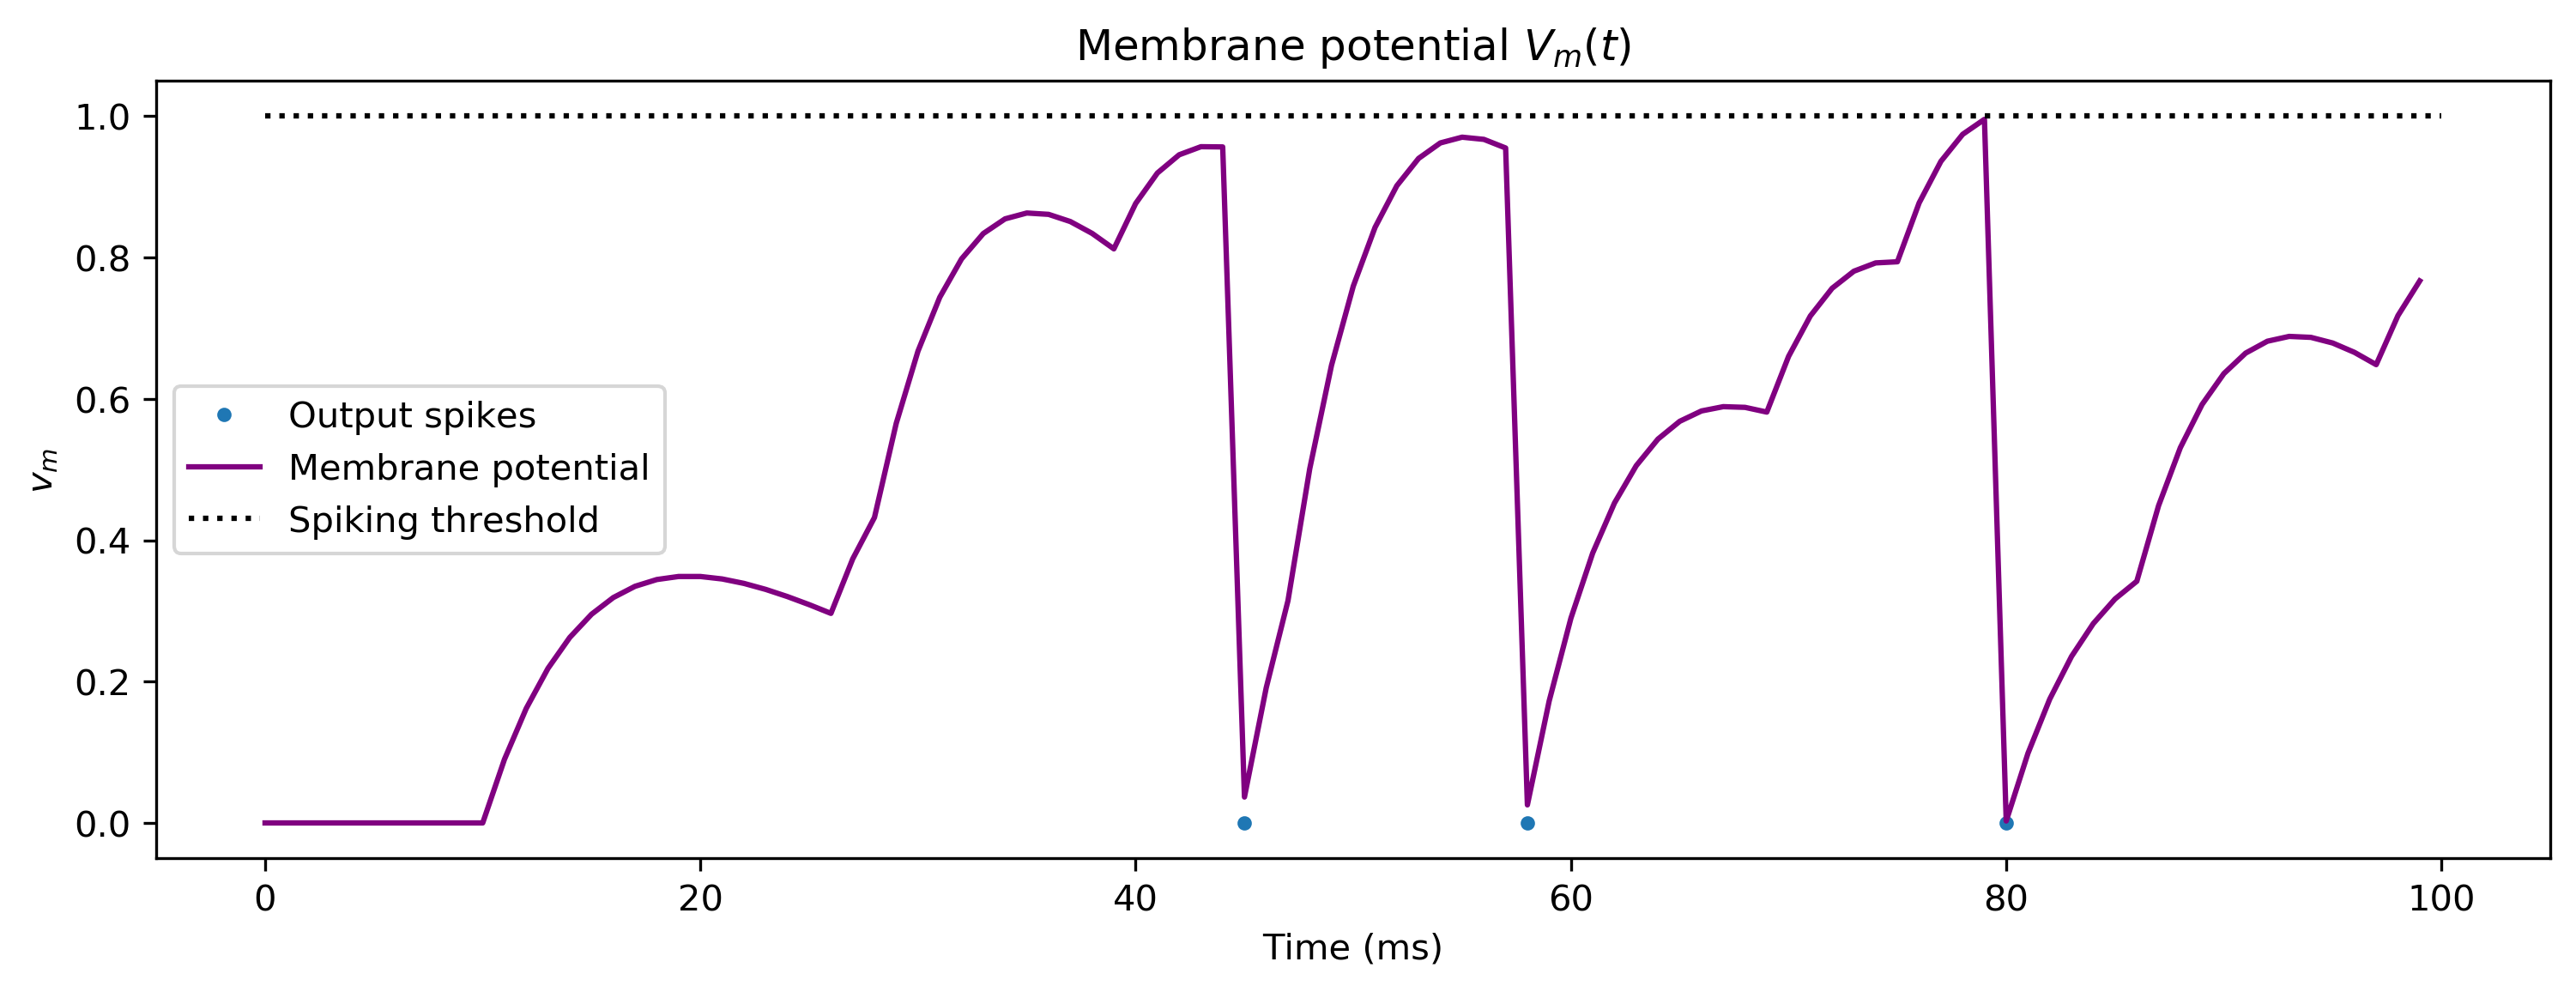

In [8]:
plt.figure()
plt.plot(spikes_t, np.zeros(len(spikes_t)), '.')
plt.plot(V_m_t, c='purple')
plt.plot([0, T], [V_th, V_th], 'k:')
plt.xlabel('Time (ms)')
plt.ylabel('$v_m$')
plt.legend(['Output spikes', 'Membrane potential', 'Spiking threshold'])
plt.title('Membrane potential $V_m(t)$');